<a href="https://colab.research.google.com/github/raigit/ML_GNN_PRACTICE/blob/master/GraphSAGE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
import torch
!pip install -q torch-scatter -f https://data.pyg.org/whl/torch-{torch.__version__}.html
!pip install -q torch-sparse -f https://data.pyg.org/whl/torch-{torch.__version__}.html
!pip install -q git+https://github.com/pyg-team/pytorch_geometric.git

# Visualization
import networkx as nx
import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 300
plt.rcParams.update({'font.size': 24})

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [6]:
# 1. PubMed dataset

from torch_geometric.datasets import Planetoid

dataset = Planetoid(root = '.', name = 'Pubmed')
data = dataset[0]

print(f'Dataset : {dataset}')
print('--------------------')
print(f'Number of graphs : {len(dataset)}')
print(f'Number of nodes : {data.x.shape[0]}')
print(f'Number of features : {dataset.num_features}')
print(f'Number of classes : {dataset.num_classes}')

print(f'\nGraph')
print('--------')
print(f'Training nodes : {sum(data.train_mask).item()}')
print(f'Evaluation nodes : {sum(data.val_mask).item()}')
print(f'Test nodes : {sum(data.test_mask).item()}')
print(f'Edges are directed : {data.is_directed()}')
print(f'Graph has isolated nodes : {data.has_isolated_nodes()}')
print(f'Graph has loops : {data.has_self_loops()}')

Dataset : Pubmed()
--------------------
Number of graphs : 1
Number of nodes : 19717
Number of features : 500
Number of classes : 3

Graph
--------
Training nodes : 60
Evaluation nodes : 500
Test nodes : 1000
Edges are directed : False
Graph has isolated nodes : False
Graph has loops : False


In [ ]:
# 2. GraphSAGE in theory

Subgraph 0: Data(x=[400, 500], edge_index=[2, 462], y=[400], train_mask=[400], val_mask=[400], test_mask=[400], n_id=[400], e_id=[462], input_id=[16], batch_size=16)
Subgraph 1: Data(x=[264, 500], edge_index=[2, 318], y=[264], train_mask=[264], val_mask=[264], test_mask=[264], n_id=[264], e_id=[318], input_id=[16], batch_size=16)
Subgraph 2: Data(x=[289, 500], edge_index=[2, 336], y=[289], train_mask=[289], val_mask=[289], test_mask=[289], n_id=[289], e_id=[336], input_id=[16], batch_size=16)
Subgraph 3: Data(x=[189, 500], edge_index=[2, 227], y=[189], train_mask=[189], val_mask=[189], test_mask=[189], n_id=[189], e_id=[227], input_id=[12], batch_size=12)


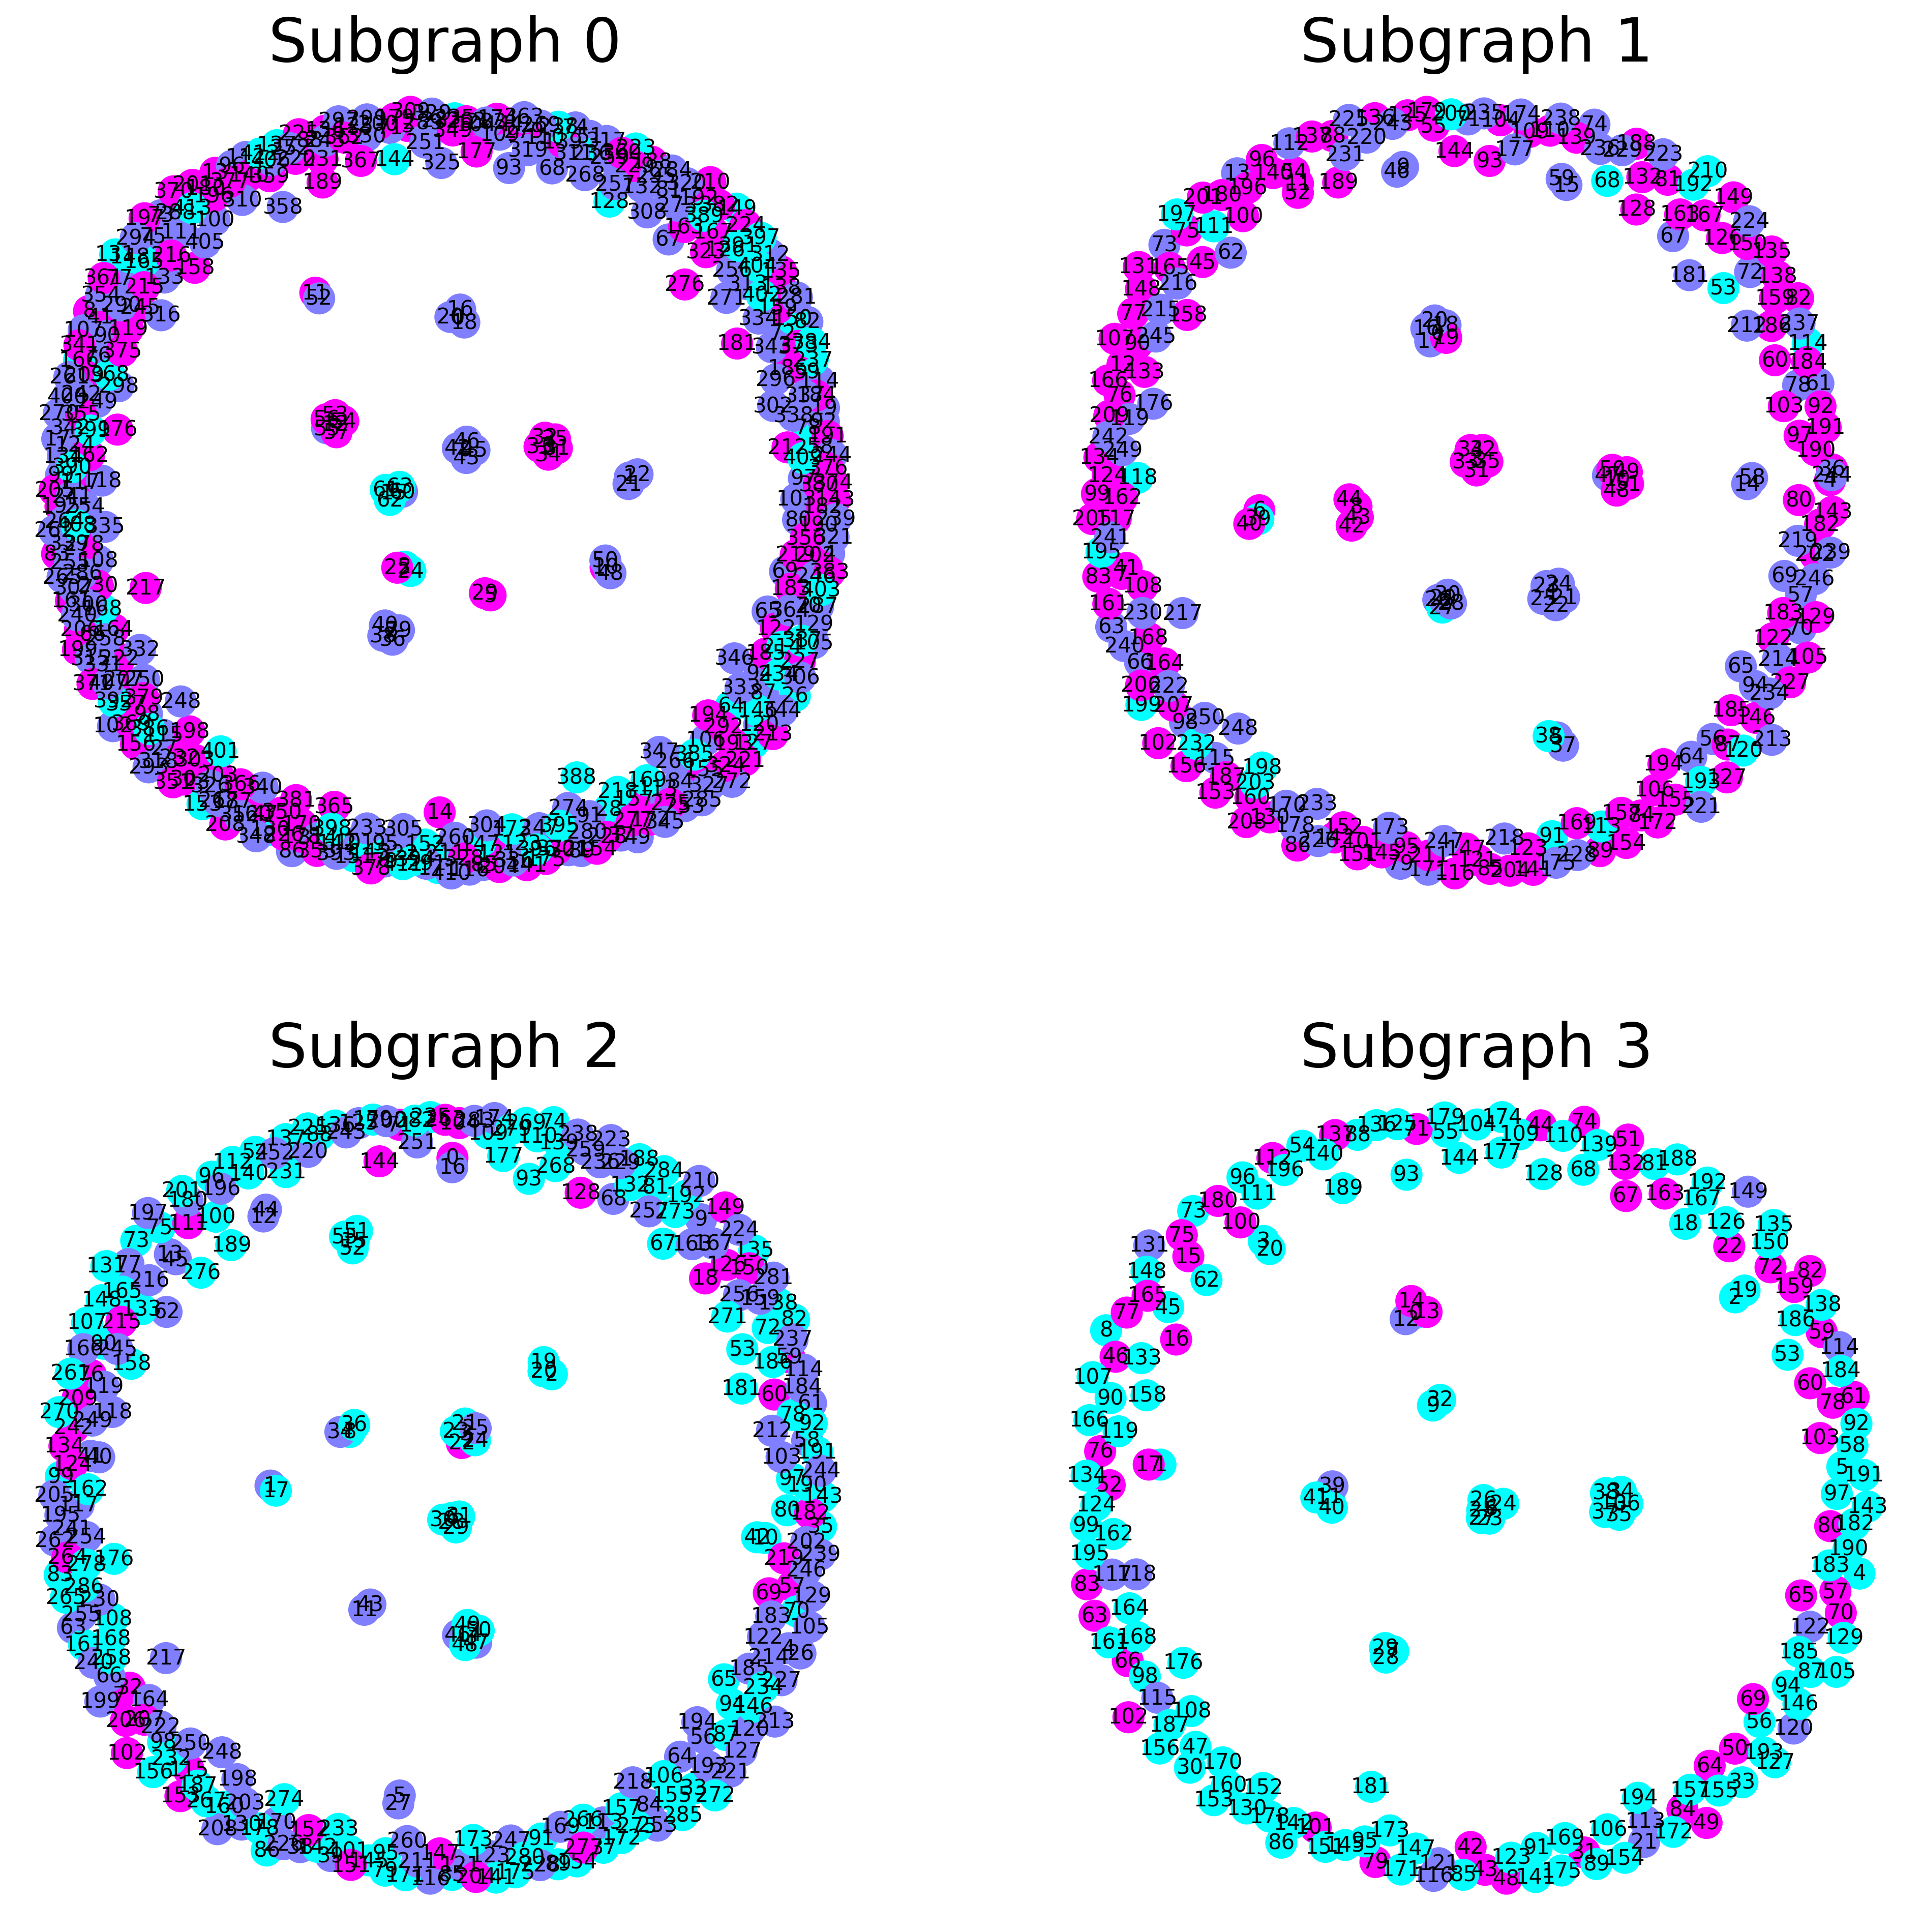

In [8]:
# The GraphSAGE algorithm can be divided into tow steps
# Neighbor sampling and Aggregation

# 2-1. Neighbor sampling
# Neighbor sampling relies on a classic technique used to train neural networks: mini-batch gradient descent
# Mini-batch gradient descent works by breaking down a dataset into smaller batches
# During training, we compute the gradient for every mini-batch instead of every epoch or every training samples
# This mini-batch has several benefits
# 1. Improved accuracy : mini-batches help to reduce overfitting as well as variance in error rates
# 2. Increased speed : mini-batches are processed in parallel and take less time to train than larger batches
# 3. Imporved scalability :

# Neighbor sampling considers only a fixed number of random neighbors
# 1. The sampler randomly selects a defined number of neighbors, neighbors of neighbors, etc
# 2. The sampler outputs subgraph containing the target and sampled nodes
# This process is repeated for every node in a list or the entirety of the graph
# However creating a subgraph for each node is not efficient, which is why we can process them in batches instead
# In this case, each subgraph is shared by multiple target nodes

# Neighbor sampling has an added benefit
# Sometimes we observe extremely popular nodes that act like hubs, such as celebrities on social media
# Calculating embeddings for these nodes can be computationally very expensive since it requires calculating the hidden vectors of thousands or even millions of neighbors
# GraphSAGE fixes this issue by only considering a fixed number of neighbors

from torch_geometric.loader import NeighborLoader
from torch_geometric.utils import to_networkx

train_loader = NeighborLoader(
    data,
    num_neighbors = [5, 10],
    batch_size = 16,
    input_nodes = data.train_mask
)

for i, subgraph in enumerate(train_loader):
    print(f'Subgraph {i}: {subgraph}')

# Plot each subgraph
fig = plt.figure(figsize=(16,16))
for idx, (subdata, pos) in enumerate(zip(train_loader, [221, 222, 223, 224])):
    G = to_networkx(subdata, to_undirected=True)
    ax = fig.add_subplot(pos)
    ax.set_title(f'Subgraph {idx}')
    plt.axis('off')
    nx.draw_networkx(G,
                    pos=nx.spring_layout(G, seed=0),
                    with_labels=True,
                    node_size=200,
                    node_color=subdata.y,
                    cmap="cool",
                    font_size=10
                    )
plt.show()

In [ ]:
# 2-2. Aggregation

# The aggregation process determines how to combine the feature vectors to produce the node embeddings

# 2-2-1. Mean aggregator
# The mean aggregator is the simplest one.
# - The hidden features of the target node and its selected neighbors are averaged
# - A linear transformation with a weight matrix W is applied
# The result can then be fed to a nonlinear activation function like ReLU

# 2-2-2. LSTM aggregator
# It assigns an order to our unordered nodes

# 2-2-3. Pooling aggregator
# It feed each neighbor's hidden vector to a feedforward neural network
# Then an elementwise max operation is applied to the result to keep the highest value for each feature

In [17]:
# 3. GraphSAGE in PyTorch Geometric

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch_geometric.nn import SAGEConv, GATv2Conv, GCNConv

class GraphSAGE(nn.Module):

  def __init__(self, dim_in, dim_h, dim_out):
    super().__init__()
    self.sage1 = SAGEConv(dim_in, dim_h)
    self.sage2 = SAGEConv(dim_h, dim_out)

  def forward(self, x, edge_index):
    h = self.sage1(x, edge_index).relu()
    h = F.dropout(h, p = 0.5, training = self.training)
    h = self.sage2(h, edge_index)
    y = F.log_softmax(h, dim = 1)
    return y

def accuracy(pred_y, y):
    """Calculate accuracy."""
    return ((pred_y == y).sum() / len(y)).item()

def train(model, data, epochs):
  crit = nn.CrossEntropyLoss()
  optimizer = optim.Adam(model.parameters(), lr = 0.01, weight_decay = 5e-4)

  model.train()
  for epoch in range(epochs + 1):
    total_loss = 0
    acc = 0
    val_loss = 0
    val_acc = 0

    for batch in train_loader:
      optimizer.zero_grad()
      out = model(batch.x, batch.edge_index)
      loss = crit(out[batch.train_mask], batch.y[batch.train_mask])
      total_loss += loss
      acc += accuracy(out[batch.train_mask].argmax(dim = 1), batch.y[batch.train_mask])
      loss.backward()
      optimizer.step()

      val_loss += crit(out[batch.val_mask], batch.y[batch.val_mask])
      val_acc += accuracy(out[batch.val_mask].argmax(dim = 1), batch.y[batch.val_mask])

      if epoch % 10 == 0:
        print(f'Epoch {epoch} | Train Loss: {total_loss/len(train_loader):.3f} '
                f'| Train Acc: {acc/len(train_loader)*100:>6.2f}% | Val Loss: '
                f'{val_loss/len(train_loader):.2f} | Val Acc: '
                f'{val_acc/len(train_loader)*100:.2f}%')

@torch.no_grad()
def test(model, data):
    """Evaluate the model on test set and print the accuracy score."""
    model.eval()
    out = model(data.x, data.edge_index)
    acc = accuracy(out.argmax(dim=1)[data.test_mask], data.y[data.test_mask])
    return acc

In [19]:
%%time

sage = GraphSAGE(dataset.num_features, 64, dataset.num_classes)
print(sage)
train(sage, data, 200)
print(f'\nGraphSAGE test accuracy: {test(sage, data)*100:.2f}%\n')

GraphSAGE(
  (sage1): SAGEConv(500, 64, aggr=mean)
  (sage2): SAGEConv(64, 3, aggr=mean)
)
Epoch 0 | Train Loss: 0.274 | Train Acc:  10.29% | Val Loss: 0.28 | Val Acc: 0.00%
Epoch 0 | Train Loss: 0.543 | Train Acc:  24.36% | Val Loss: 0.55 | Val Acc: 16.67%
Epoch 0 | Train Loss: 0.826 | Train Acc:  27.30% | Val Loss: 0.83 | Val Acc: 16.67%
Epoch 0 | Train Loss: 1.136 | Train Acc:  27.30% | Val Loss: 1.12 | Val Acc: 16.67%
Epoch 10 | Train Loss: 0.033 | Train Acc:  25.00% | Val Loss: 0.22 | Val Acc: 12.50%
Epoch 10 | Train Loss: 0.060 | Train Acc:  50.00% | Val Loss: 0.43 | Val Acc: 25.00%
Epoch 10 | Train Loss: 0.084 | Train Acc:  75.00% | Val Loss: 0.61 | Val Acc: 45.45%
Epoch 10 | Train Loss: 0.110 | Train Acc: 100.00% | Val Loss: 0.76 | Val Acc: 66.29%
Epoch 20 | Train Loss: 0.008 | Train Acc:  25.00% | Val Loss: 0.22 | Val Acc: 11.36%
Epoch 20 | Train Loss: 0.020 | Train Acc:  50.00% | Val Loss: 0.41 | Val Acc: 17.61%
Epoch 20 | Train Loss: 0.031 | Train Acc:  75.00% | Val Loss: 0.